# __Commonly used geoprocesses__

## __Import libraries__

In [1]:
from pathlib import Path

current_path = Path().resolve()

for parent in current_path.parents:
    if parent.name == "accesibilidad-urbana":
        project_root = parent
        break

print(project_root)

/home/jovyan/accesibilidad-urbana


In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join(project_root))
if module_path not in sys.path:
    print(f"Path found.")
    sys.path.append(module_path)
    import aup
else:
    print(f"Path NOT found.")
    import aup

Path found.


## __Notebook config__

In [3]:
res = 8
city = 'Aguascalientes'
hex_type = 'urban'

## __Load data__

### __Load data__ - Clipping mask

In [4]:
hex_schema = 'hexgrid'
hex_table = f'hexgrid_{res}_city_2020'
query = f"SELECT * FROM {hex_schema}.{hex_table} WHERE \"city\" = '{city}\' AND \"type\" = '{hex_type}\'"
hex_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Show
print(hex_gdf.crs)
print(hex_gdf.shape)
hex_gdf.head(2)

epsg:4326
(323, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88498e3639fffff,"POLYGON ((-102.27184 21.89588, -102.26725 21.8...",01001,Aguascalientes,Aguascalientes,urban
1,88498e3657fffff,"POLYGON ((-102.28972 21.87858, -102.28512 21.8...",01001,Aguascalientes,Aguascalientes,urban


In [5]:
hex_gdf.to_crs("EPSG:6372",inplace=True)
hex_gdf_buff = pd.DataFrame(hex_gdf.buffer(5))
hex_gdf_buff.rename(columns={0:'geometry'},inplace=True)
hex_gdf_buff = gpd.GeoDataFrame(hex_gdf_buff,geometry='geometry',crs="EPSG:6372")
aoi_gdf = hex_gdf_buff.dissolve()

# Show
print(aoi_gdf.crs)
print(aoi_gdf.shape)
aoi_gdf.head(2)

EPSG:6372
(1, 1)


,geometry
0,"MULTIPOLYGON (((2465725.680 1089577.718, 24657..."


### __Load data__ - Data to be clipped (Economical activities in those municipalities)

In [6]:
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020'
query = f"SELECT * FROM {metro_schema}.{metro_table} WHERE \"city\" LIKE \'{city}\'"
mun_gdf = aup.gdf_from_query(query, geometry_col='geometry')

# Aguascalientes municipalities dissolved
poly_wkt = mun_gdf.dissolve().geometry.to_wkt()[0]

# Iterate over each code looking where the points intersect with the municipalities
denue_schema = 'denue'
denue_table = 'denue_23_point'
query = f"SELECT * FROM {denue_schema}.{denue_table} WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
denue_gdf = aup.gdf_from_query(query, geometry_col='geometry')
denue_gdf.to_crs("EPSG:6372",inplace=True)

# Show
print(denue_gdf.crs)
print(denue_gdf.shape)
denue_gdf.head(2)

EPSG:6372
(52600, 43)


,id,clee,nom_estab,raz_social,codigo_act,nombre_act,per_ocu,tipo_vial,nom_vial,tipo_v_e_1,...,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta,geometry
0,8499818.0,01005435419000164000000000U9,SERVICIO DE ELECTRO BOMBAS SUMERGIBLES,ELECTRO BOMBAS SUMERGIBLES SA DE CV,435419,Comercio al por mayor de otra maquinaria y equ...,31 a 50 personas,CARRETERA,LOCALIDAD 800,None,...,0035,800.0,4499148765,None,WWW.ELECTTROBOMBAS.COM.MX,Fijo,21.95442,-102.29128,2019-11,POINT (2470064.438 1104127.523)
1,6236555.0,01005327320000033000008866S7,CEMEX SAB PD0615 AGUASCALIENTES,CEMEX SAB DE CV,327320,Fabricación de concreto,51 a 100 personas,CALLE,AGUASCALIENTES LORETO,CALLE,...,0035,11.0,None,None,None,Fijo,21.96107,-102.28042,2014-12,POINT (2471182.405 1104857.807)


<Axes: >

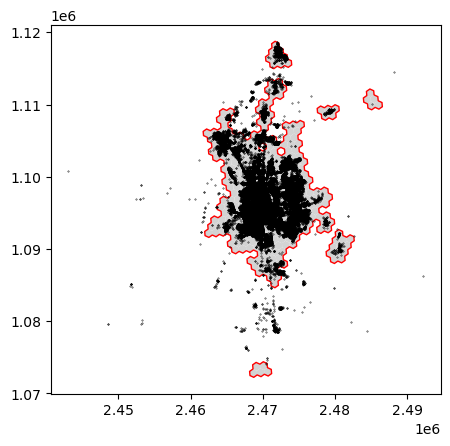

In [7]:
fig,ax = plt.subplots()

denue_gdf.plot(ax=ax,zorder=2,markersize=0.1,color='black')
aoi_gdf.plot(ax=ax,zorder=1,facecolor='none',lw=1,edgecolor='red')
hex_gdf.plot(ax=ax,zorder=0,color='lightgrey')

## __Geoprocesses__

### __Geoprocesses__ - left or right __sjoin__

__NOTE:__ A left (or right) sjoin __creates VARIOUS instances__ of the left (or right) gdf, __one for each time it finds anything from the other gdf__

In [16]:
sjoin_left = gpd.sjoin(hex_gdf, denue_gdf, how='left')

# Show
print(len(sjoin_left))
print(len(sjoin_left.loc[sjoin_left.hex_id_8=='88498e3639fffff']))
sjoin_left.head(5)

51382
294


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type,index_right,id,clee,nom_estab,...,localidad,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12890.0,7304.0,01001811111009211000000000U5,DIAGNOSTICOS EXACTOS AUTOMOTECES,...,Aguascalientes,1636,50.0,4491017582.0,None,None,Fijo,21.896252,-102.271324,2010-07
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12797.0,44010.0,01001462112002741000000000U8,MINI SUPER STEMA,...,Aguascalientes,3223,26.0,None,None,None,Fijo,21.896292,-102.271560,2014-12
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12748.0,43779.0,01001461110045161000000000U3,ABARROTES SANTY,...,Aguascalientes,2564,41.0,None,None,None,Fijo,21.896755,-102.270650,2014-12
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12792.0,7702788.0,01001467113001791000000000U7,TIENDA DE PINTURAS COLOR INK,...,Aguascalientes,3223,25.0,None,COLOR.INK033@GMAIL.COM,None,Fijo,21.896770,-102.271280,2019-11
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12879.0,6979665.0,01001621211009971000000000U2,CONSULTORIO DENTAL SIN NOMBRE,...,Aguascalientes,3223,25.0,4498062951.0,None,None,Fijo,21.897032,-102.271480,2019-11


In [20]:
sjoin_right = gpd.sjoin(hex_gdf, denue_gdf, how='right')

# Show
print(len(sjoin_right))
print(len(sjoin_right.loc[sjoin_right.hex_id_8=='88498e3639fffff']))
sjoin_right.head(5)

52600
294


,index_left,hex_id_8,CVEGEO,NOMGEO,city,type,id,clee,nom_estab,raz_social,...,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta,geometry
0,NaN,NaN,NaN,NaN,NaN,NaN,8499818.0,01005435419000164000000000U9,SERVICIO DE ELECTRO BOMBAS SUMERGIBLES,ELECTRO BOMBAS SUMERGIBLES SA DE CV,...,0035,800.0,4499148765,None,WWW.ELECTTROBOMBAS.COM.MX,Fijo,21.954420,-102.29128,2019-11,POINT (2470064.438 1104127.523)
1,256.0,88498e34cdfffff,01005,Jesús María,Aguascalientes,urban,6236555.0,01005327320000033000008866S7,CEMEX SAB PD0615 AGUASCALIENTES,CEMEX SAB DE CV,...,0035,11.0,None,None,None,Fijo,21.961070,-102.28042,2014-12,POINT (2471182.405 1104857.807)
2,250.0,88498e36b5fffff,01005,Jesús María,Aguascalientes,urban,8916052.0,01005435110000113000000000U1,VENTA DE EQUIPOS LECHEROS ELECSA,EQUIPOS LECHEROS SA DE CV,...,0618,9.0,4499127387,None,WWW.EQUIPOSLECHEROS.COM.MX,Fijo,21.961832,-102.29720,2019-11,POINT (2469457.681 1104945.332)
3,250.0,88498e36b5fffff,01005,Jesús María,Aguascalientes,urban,6252572.0,01005337210000095001000000U7,PRODITEK DEL CENTRO SA DE CV,PRODITEK DEL CENTRO SA DE CV,...,0035,6.0,None,RECURSOSHUMANOS@PRODITEK.COM.MX,None,Fijo,21.960630,-102.29769,2014-12,POINT (2469407.228 1104813.055)
4,250.0,88498e36b5fffff,01005,Jesús María,Aguascalientes,urban,6856091.0,01005335312000012001000000U8,PULSE ENERGY,PULSE ENERGY S DE RL DE CV,...,0035,6.0,None,JOSEJAIMERT@ME.COM,None,Fijo,21.959154,-102.29604,2019-04,POINT (2469576.246 1104650.065)


__NOTE: It keeps all specified gdf (left or right) geometries__ even when they intersected nothing.

In [11]:
sjoin_left_withoutdata = sjoin_left.loc[sjoin_left.index_right.isna()]

#Show
print(len(sjoin_left_withoutdata))
sjoin_left_withoutdata.head(2)

46


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type,index_right,id,clee,nom_estab,...,localidad,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta
5,88498e3709fffff,"POLYGON ((2478750.184 1095687.681, 2479223.015...",01001,Aguascalientes,Aguascalientes,urban,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,88498e3701fffff,"POLYGON ((2479172.764 1096593.469, 2479645.591...",01001,Aguascalientes,Aguascalientes,urban,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### __Geoprocesses__ - inner __sjoin__

__NOTE:__ An inner sjoin also __creates VARIOUS instances__ of the __left__ gdf, __one for each time it finds anything from the right gdf__

In [15]:
sjoin_inner = gpd.sjoin(hex_gdf, denue_gdf, how='inner')

# Show
print(len(sjoin_inner))
print(len(sjoin_inner.loc[sjoin_inner.hex_id_8=='88498e3639fffff']))
sjoin_inner.head(5)

51336
294


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type,index_right,id,clee,nom_estab,...,localidad,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12890,7304.0,01001811111009211000000000U5,DIAGNOSTICOS EXACTOS AUTOMOTECES,...,Aguascalientes,1636,50.0,4491017582.0,None,None,Fijo,21.896252,-102.271324,2010-07
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12797,44010.0,01001462112002741000000000U8,MINI SUPER STEMA,...,Aguascalientes,3223,26.0,None,None,None,Fijo,21.896292,-102.271560,2014-12
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12748,43779.0,01001461110045161000000000U3,ABARROTES SANTY,...,Aguascalientes,2564,41.0,None,None,None,Fijo,21.896755,-102.270650,2014-12
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12792,7702788.0,01001467113001791000000000U7,TIENDA DE PINTURAS COLOR INK,...,Aguascalientes,3223,25.0,None,COLOR.INK033@GMAIL.COM,None,Fijo,21.896770,-102.271280,2019-11
0,88498e3639fffff,"POLYGON ((2472049.849 1097674.621, 2472522.771...",01001,Aguascalientes,Aguascalientes,urban,12879,6979665.0,01001621211009971000000000U2,CONSULTORIO DENTAL SIN NOMBRE,...,Aguascalientes,3223,25.0,4498062951.0,None,None,Fijo,21.897032,-102.271480,2019-11


__NOTE: But an inner sjoin does NOT keep all left geometries__, it drops them when they intersected nothing.

In [17]:
sjoin_inner_withoutdata = sjoin_inner.loc[sjoin_inner.index_right.isna()]

#Show
print(len(sjoin_inner_withoutdata))
sjoin_inner_withoutdata.head(2)

0


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type,index_right,id,clee,nom_estab,...,localidad,ageb,manzana,telefono,correoelec,www,tipounieco,latitud,longitud,fecha_alta


### __Geoprocesses__ - __overlay__

__NOTE: Depends on the overlay type.__ More info in https://geopandas.org/en/stable/docs/user_guide/set_operations.html

#### __overlay - intersection__ Commonly used, similar to GIS Clip. 
#### In this case it doesn't keep any information from the original denue point because a buffer without data is used in the overlay. Example of usage in script22-censo_pop_voronoi.py

In [42]:
# Create a 500m buffer around a random denue point
denue_chosen = denue_gdf.loc[denue_gdf.clee=='01001811111009211000000000U5']
denue_chosen_buffer = pd.DataFrame(denue_chosen.buffer(1500))
denue_chosen_buffer.rename(columns={0:'geometry'},inplace=True)
denue_chosen_buffer = gpd.GeoDataFrame(denue_chosen_buffer)

# Overlay
hex_denue_overlay = gpd.overlay(df1=denue_chosen_buffer, df2=hex_gdf, how="intersection")

# Show
hex_denue_overlay.head(2)

,hex_id_8,CVEGEO,NOMGEO,city,type,geometry
0,88498e3639fffff,01001,Aguascalientes,Aguascalientes,urban,"POLYGON ((2471526.644 1097915.719, 2471476.367..."
1,88498e360bfffff,01001,Aguascalientes,Aguascalientes,urban,"POLYGON ((2471668.050 1096279.709, 2471529.452..."


<Axes: >

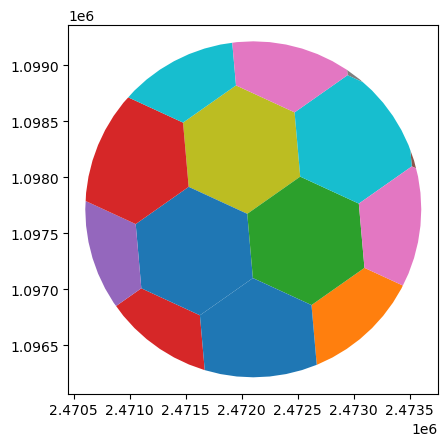

In [43]:
hex_denue_overlay.plot('hex_id_8')